In [31]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


In [32]:
train_data = pd.read_csv("part1_train.csv", header=None)
test_data = pd.read_csv("part1_test.csv", header=None)
print("Training Data Samples:")
print(train_data.head())
print("\nTesting Data Samples:")
print(test_data.head())

Training Data Samples:
   0                  1       2           3   4                    5   \
0  39          State-gov   77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12  \
0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <


Column Names: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Unique income values before mapping:
['<=50K' '>50K']

Income Value Counts (Encoded):
income
0    24720
1     7841
Name: count, dtype: int64


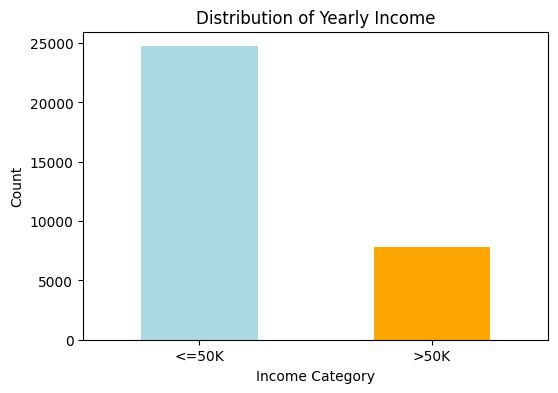

In [33]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "gender",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
train_data.columns = column_names
test_data.columns = column_names

print("\nColumn Names:", train_data.columns)

target_column = "income"
train_data[target_column] = train_data[target_column].astype(str)
train_data[target_column] = train_data[target_column].str.strip().str.replace(".", "", regex=False)

print("\nUnique income values before mapping:")
print(train_data[target_column].unique())

train_data[target_column] = train_data[target_column].map({"<=50K": 0, ">50K": 1})
train_data = train_data.dropna(subset=[target_column])

print("\nIncome Value Counts (Encoded):")
print(train_data[target_column].value_counts())

plt.figure(figsize=(6, 4))
train_data[target_column].value_counts().plot(kind="bar", color=["lightblue", "orange"])
plt.title("Distribution of Yearly Income")
plt.xticks(ticks=[0, 1], labels=["<=50K", ">50K"], rotation=0)
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
train_data.replace("?", "Unknown", inplace=True)
test_data.replace("?", "Unknown", inplace=True)

X = train_data.drop(columns=["income"])
y = train_data["income"]

print("Are there any NaN values in target y?", y.isna().sum())

X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(test_data.drop(columns=["income"]), drop_first=True)

X_test = X_test.reindex(columns=X.columns, fill_value=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Are there any NaN values in y_train?", y_train.isna().sum())
print("Are there any NaN values in y_val?", y_val.isna().sum())

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)


Are there any NaN values in target y? 0
Are there any NaN values in y_train? 0
Are there any NaN values in y_val? 0


LogisticRegressionModel(
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch [1/30], Loss: 0.5657, Train Acc: 0.7939, Val Acc: 0.7940
Epoch [2/30], Loss: 0.4427, Train Acc: 0.8297, Val Acc: 0.8322
Epoch [3/30], Loss: 0.3936, Train Acc: 0.8426, Val Acc: 0.8451
Epoch [4/30], Loss: 0.3658, Train Acc: 0.8487, Val Acc: 0.8492
Epoch [5/30], Loss: 0.3493, Train Acc: 0.8506, Val Acc: 0.8503
Epoch [6/30], Loss: 0.3394, Train Acc: 0.8519, Val Acc: 0.8532
Epoch [7/30], Loss: 0.3333, Train Acc: 0.8521, Val Acc: 0.8532
Epoch [8/30], Loss: 0.3294, Train Acc: 0.8520, Val Acc: 0.8548
Epoch [9/30], Loss: 0.3272, Train Acc: 0.8525, Val Acc: 0.8558
Epoch [10/30], Loss: 0.3256, Train Acc: 0.8520, Val Acc: 0.8567
Epoch [11/30], Loss: 0.3246, Train Acc: 0.8526, Val Acc: 0.8569
Epoch [12/30], Loss: 0.3240, Train Acc: 0.8523, Val Acc: 0.8554
Epoch [13/30], Loss: 0.3235, Train Acc: 0.8519, Val Acc: 0.8574
Epoch [14/30], Loss: 0.3233, Train Acc: 0.8526, Val Acc: 0.8566


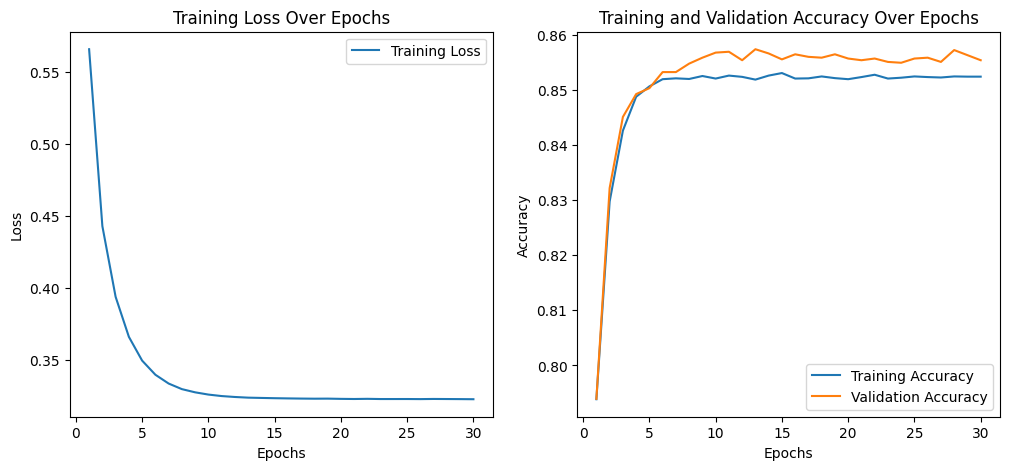


Total model parameters: 101


In [37]:
# Define Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Single layer: input -> output
        self.sigmoid = nn.Sigmoid()             # Sigmoid activation

    def forward(self, x):
        return self.sigmoid(self.linear(x))

# Initialize the model
input_size = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_size).to(device)
print(model)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute accuracy
def compute_accuracy(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Training the model
num_epochs = 30
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Compute training and validation accuracy
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    
    # Store metrics
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()

# Report total model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal model parameters: {total_params}")
